## ANALYSIS OF LIFE CYCLE OF MJO :
RMM index has been obtainded from http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt


In [1]:
from scipy.io import loadmat
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sc
import scipy as sp
import scipy.fftpack
from scipy import stats,signal
from scipy.stats import norm
import xarray as xr
import matplotlib.mlab as mlab
import nclcmaps 
import regression_analysis as rig  ### loading regression library
import matplotlib.pyplot as plt
import MJO_frequency_stats_long_seas as mfs ## loading a library for our analysis

%matplotlib inline

/home/panini/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/panini/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Fiddle with figure settings here:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)


## Functions:
    1.Mann-Kendall Test 2. Filtering signal

In [3]:
def mk_test(x, alpha=0.05):
    """
    This code is written by @author: Michael Schramm
    This function is derived from code originally posted by Sat Kumar Tomer
    (satkumartomer@gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert
    1987) is to statistically assess if there is a monotonic upward or downward
    trend of the variable of interest over time. A monotonic upward (downward)
    trend means that the variable consistently increases (decreases) through
    time, but the trend may or may not be linear. The MK test can be used in
    place of a parametric linear regression analysis, which can be used to test
    if the slope of the estimated linear regression line is different from
    zero. The regression analysis requires that the residuals from the fitted
    regression line be normally distributed; an assumption not required by the
    MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best
    viewed as an exploratory analysis and is most appropriately used to
    identify stations where changes are significant or of large magnitude and
    to quantify these findings.
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics
    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(x == unique_x[i])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z


def filter_signal_scipy(signal,sample_freq,ltime_period,htime_period,opt_show_psd,keep_mean):
    if any(np.isnan(signal)):
        filter_signal=signal
    else:
        hf=1./ltime_period
        lf=1./htime_period

        temp_fft = sc.fftpack.fft(signal)
        temp_psd = np.abs(temp_fft) ** 2

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
        i = fftfreq > 0

        if opt_show_psd:
            fig, ax = plt.subplots(1, 1, figsize=(8, 4))
            ax.plot(1/fftfreq[i], 10 * np.log10(temp_psd[i]))
            ax.set_xlabel('Time Period (year)')
            ax.set_ylabel('PSD (dB)')

        i1=(np.abs(fftfreq) >= lf) & (np.abs(fftfreq) <= hf)  
        inv_fft=np.zeros(temp_fft.size)
        inv_fft[i1]=temp_fft[i1]
        if keep_mean:
            inv_fft[0]=temp_fft[0]
        filter_signal=sc.fftpack.ifft(inv_fft)
    
    return filter_signal

## Reading RMM.txt ######



In [4]:
matrix1=np.loadtxt('/home/panini/DATA/indices/rmm.txt',usecols=range(7),skiprows=1)
year=matrix1[:,0]
strt_ind=np.where(year==1982)[0][0]-61
strt_ind
pcs=matrix1[:,3:5] 
time=matrix1[:,0:3] 
phase=matrix1[:,5]
pc11_rmm=pcs[:,0]
pc22_rmm=pcs[:,1]
MJO_index_rmm_org=(pc11_rmm**2+pc22_rmm**2)**0.5
time[strt_ind]


theta1_rmm_org=mfs.theta1_cal(pc11_rmm,pc22_rmm) 
the1_org,amp_org=mfs.theta1_winter(theta1_rmm_org,MJO_index_rmm_org,1981,37,strt_ind,181)


##################################### Extra days within 25 th oct to 5 th of may added for our analysis ###################
the1_org[6]=matrix1[4896:5083,5];
amp_org[6]=matrix1[4896:5083,6];
##### year 1988-1989%%%
the1_org[7]=matrix1[5267:5452,5];
amp_org[7]=matrix1[5267:5452,6];
##### year 1998-1999 %%%%
the1_org[17]=matrix1[8919:9105,5];
amp_org[17]=matrix1[8919:9105,6];
##### year 2001-2002#####%
the1_org[20]=matrix1[10010:10196,5];
amp_org[20]=matrix1[10010:10196,6];
##### year 2002-2003#####%
the1_org[21]=matrix1[10373:10561,5];
amp_org[21]=matrix1[10373:10561,6];
##### year 2008-2009%%%%
the1_org[27]=matrix1[12572:12758,5];
amp_org[27]=matrix1[12572:12758,6];
#####% year 2009 -2010 #####
the1_org[28]=matrix1[12934:13118,5];
amp_org[28]=matrix1[12934:13118,6];
#####year 2013-2014#####
the1_org[32]=matrix1[14398:14582,5];
amp_org[32]=matrix1[14398:14582,6];
#################################################################################################################

## MJO history 1981-2018

In [5]:
opt=0   #### if opt =1 we only count the days when RMM>1.0
###################################### MJO_88.mat is the history of MJO start and ending dos (day of the season) ####
x            =     loadmat('MJO_88.mat')  ### Reading the list of events from matfile 
mjo_analysis  =     x["mjo_rmm_prop"]

k=0


av_analysis=np.zeros((37,11))
ap_analysis =np.zeros((88,11))




for i in np.arange(mjo_analysis.shape[1]):
    
    mat=mjo_analysis[0][i];
    #### start date and end date#####
    doy1         =         mat[:,0]-1
    doy2         =         mat[:,1]

    
    y            =          1981+i
    nn           =          len(mat)
    
    phase11= the1_org[i]*1
    amp11= amp_org[i]*1

    if opt:
        phase11[amp11<1.0]=0
        
    phase1=phase11.tolist()

    
    ph1=[];ph2=[];ph3=[];l=0;
    for j in np.arange(len(mat)):
        l=l+1   
        temp1=np.asarray(phase1[int(doy1[j]):int(doy2[j])])
        

        for h in np.arange(1,9,1):
            ap_analysis[k,h-1]=np.size(np.where(temp1==h)[0])
            
        
        ap_analysis[k,8]=np.size(np.where(temp1==1)[0])+np.size(np.where(temp1==2)[0])+np.size(np.where(temp1==3)[0])
        ap_analysis[k,9]=np.size(np.where(temp1==5)[0])+np.size(np.where(temp1==6)[0])+np.size(np.where(temp1==7)[0])
        ap_analysis[k,10]=len(temp1)
        
        k=k+1


        ph1=ph1+phase1[int(doy1[j]):int(doy2[j])]
        

    ph11=np.asarray(ph1)
    
    for h in np.arange(1,9,1):
            av_analysis[i,h-1]=np.size(np.where(ph11==h)[0])/l

    
    av_analysis[i,8]=(np.size(np.where(ph11==1)[0])+np.size(np.where(ph11==2)[0])+np.size(np.where(ph11==3)[0]))/l
    av_analysis[i,9]=(np.size(np.where(ph11==5)[0])+np.size(np.where(ph11==6)[0])+np.size(np.where(ph11==7)[0]))/l
    av_analysis[i,10]=np.sum(av_analysis[i,0:8])


       
rmm_anal_ap=pd.DataFrame(ap_analysis,columns=['p1','p2','p3','p4','p5','p6','p7','p8','p123','p567','lf'],index=np.arange(0,88,1))        
rmm_anal_av=pd.DataFrame(av_analysis,columns=['p1','p2','p3','p4','p5','p6','p7','p8','p123','p567','lf'],index=np.arange(1981,2018,1))    


### rmm_anal_ap and rmm_anal_av are the two dataframe for individual and seasonal average phase counts of 88 MJO over 37 seasons

## Slope in all MJO events: 

(0.013940330759602732, 1.0, 0.041216682147143927, 1.0)

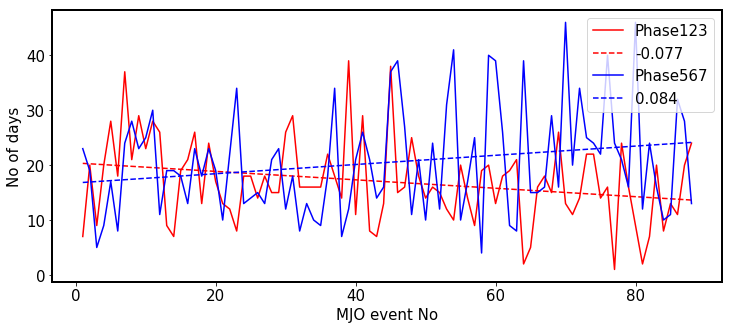

In [40]:
##### Student ttest ###########################
xx=np.arange(1,len(ap_analysis)+1)
slope1,intercept1,p1,corr1,h1=rig.linear_regress_scipy(xx,rmm_anal_ap['p123'].values,0.05,opt_detrend=0,opt_mktest=0)
slope2,intercept2,p2,corr2,h2=rig.linear_regress_scipy(xx,rmm_anal_ap['p567'].values,0.05,opt_detrend=0,opt_mktest=0)


plt.figure(figsize=(12,5))

plt.plot(xx,rmm_anal_ap['p123'],'r')
plt.plot(xx,slope1*xx+intercept1,'r',linestyle='--')
plt.plot(xx,rmm_anal_ap['p567'],'b')
plt.plot(xx,slope2*xx+intercept2,'b',linestyle='--')
plt.legend(['Phase123',str(round(slope1,3)),'Phase567',str(round(slope2,3))])
plt.xlabel('MJO event No')
plt.ylabel('No of days')

# plt.savefig("trend_123_567_88.pdf",format='pdf', dpi=1000)
p1,h1,p2,h2

## Draw PDF for phase 1,2,3


/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':
/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.
/home/panini/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.])

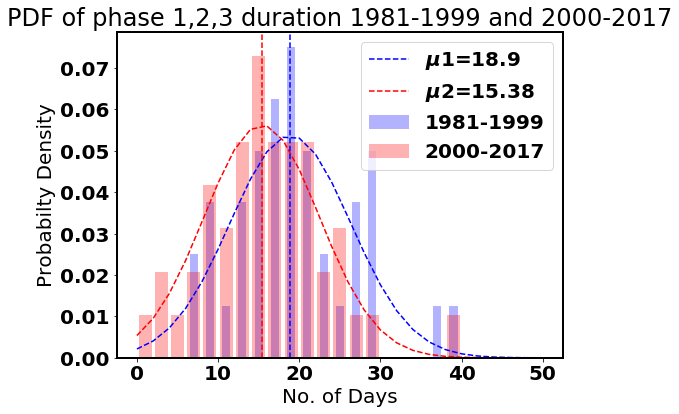

In [7]:
from scipy.stats import norm

no_123_ist=rmm_anal_ap['p123'][0:40]
no_123_2nd=rmm_anal_ap['p123'][40:]
bins = np.linspace(0, 50, 26)

mu1, std1 = norm.fit(no_123_ist)
mu2, std2 = norm.fit(no_123_2nd)
y1 = mlab.normpdf(bins, mu1, std1)
y2 = mlab.normpdf(bins, mu2, std2)

plt.figure(figsize=(8,6))

plt.hist(no_123_ist, bins, normed=1, facecolor='blue', alpha=0.3,rwidth=0.5)
plt.plot(bins, y1, 'b--')
plt.hist(no_123_2nd, bins, normed=1, facecolor='red', alpha=0.3,rwidth=0.8)
plt.plot(bins, y2, 'r--')


plt.xlabel('No. of Days')
plt.ylabel('Probabilty Density')
plt.legend(['$\mu$1='+str(round(mu1,2)),'$\mu$2='+str(round(mu2,2)),'1981-1999','2000-2017',])
plt.axvline(x=mu1,color='b',linestyle='--')
plt.axvline(x=mu2,color='r',linestyle='--')

plt.title("PDF of phase 1,2,3 duration 1981-1999 and 2000-2017")
# plt.savefig('PDF_88_123_adding.pdf',format='pdf', dpi=1000)
bins

## MW test for phase 123

In [8]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu
no_123_ist=rmm_anal_ap['p123'][0:40]
no_123_2nd=rmm_anal_ap['p123'][40:]
stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=713.500, p=0.019
Different distribution (reject H0)


## Moving window MK test

([<matplotlib.axis.XTick at 0x7f956d18abe0>,
 <a list of 3 Text xticklabel objects>)

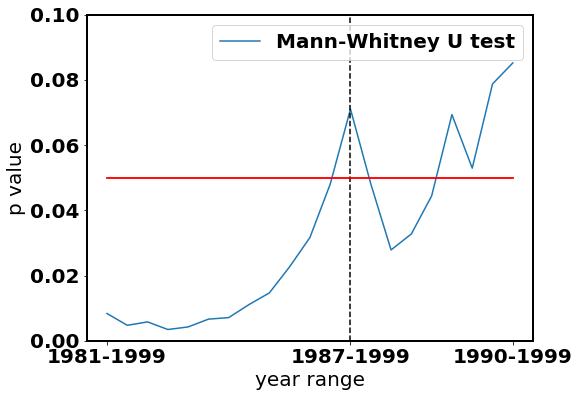

In [9]:
pvalues=[]
for i in np.arange(0,21):
    no_123_ist=rmm_anal_ap['p123'][i:41]
    no_123_2nd=rmm_anal_ap['p123'][41:]
    stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
    pvalues.append(p)

plt.figure(figsize=(8,6))
plt.plot(pvalues)
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.legend(["Mann-Whitney U test"])
plt.ylabel("p value")
plt.xlabel("year range")
plt.ylim([0,.1])
plt.axvline(x=12,color='black',linestyle='--')
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.xticks([0,12,20], ('1981-1999', '1987-1999', '1990-1999'))
# plt.savefig("mann-whitney_phase123.pdf")

## Draw PDF of 5,6,7

/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':
/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'PDF of phase 5,6,7 duration 1981-1999 and 2000-2017')

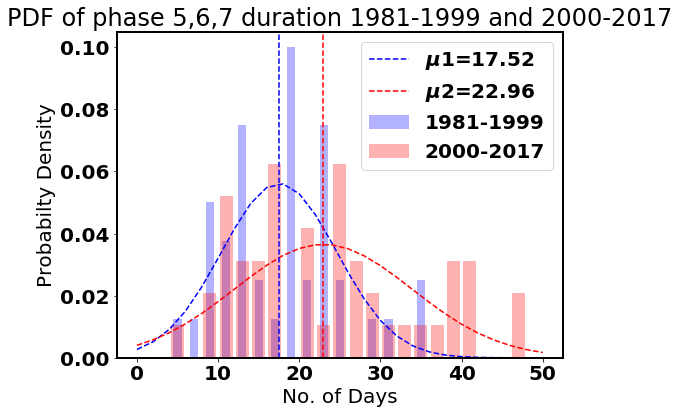

In [10]:
no_567_ist=rmm_anal_ap['p567'][0:40]
no_567_2nd=rmm_anal_ap['p567'][40:]
bins = np.linspace(0, 50, 26)



mu1, std1 = norm.fit(no_567_ist)
mu2, std2 = norm.fit(no_567_2nd)
y1 = mlab.normpdf(bins, mu1, std1)
y2 = mlab.normpdf(bins, mu2, std2)

plt.figure(figsize=(8,6))
plt.hist(no_567_ist, bins, normed=1, facecolor='blue', alpha=0.3,rwidth=0.5)
plt.plot(bins, y1, 'b--')
plt.hist(no_567_2nd, bins, normed=1, facecolor='red', alpha=0.3,rwidth=0.8)
plt.plot(bins, y2, 'r--')


plt.xlabel('No. of Days')
plt.ylabel('Probabilty Density')
plt.legend(['$\mu$1='+str(round(mu1,2)),'$\mu$2='+str(round(mu2,2)),'1981-1999','2000-2017',])
plt.axvline(x=mu1,color='b',linestyle='--')
plt.axvline(x=mu2,color='r',linestyle='--')
plt.title("PDF of phase 5,6,7 duration 1981-1999 and 2000-2017")
# plt.savefig('PDF_88_567_adding.pdf',format='pdf', dpi=1000)
# plt.savefig('fig2.png')

## MW  test

In [11]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu
no_567_ist=rmm_anal_ap['p567'][0:40]
no_567_2nd=rmm_anal_ap['p567'][40:]
stat, p = mannwhitneyu(no_567_ist, no_567_2nd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=689.000, p=0.012
Different distribution (reject H0)


## Moving window MK test

([<matplotlib.axis.XTick at 0x7f956d0936a0>,
 <a list of 3 Text xticklabel objects>)

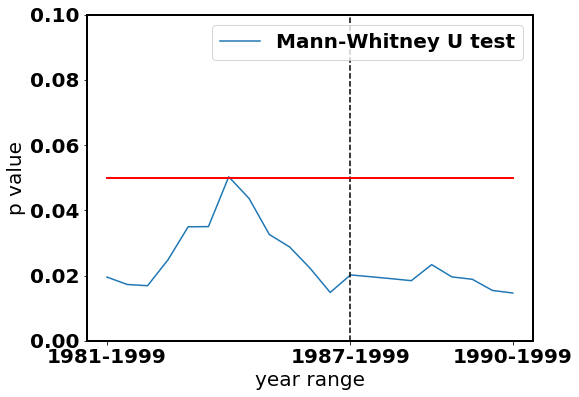

In [12]:
pvalues=[]
for i in np.arange(0,21):
    no_123_ist=rmm_anal_ap['p567'][i:41]
    no_123_2nd=rmm_anal_ap['p567'][41:]
    stat, p = mannwhitneyu(no_123_ist, no_123_2nd)
    pvalues.append(p)

plt.figure(figsize=(8,6))
plt.plot(pvalues)
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.legend(["Mann-Whitney U test"])
plt.ylabel("p value")
plt.xlabel("year range")
plt.ylim([0,.1])
plt.axvline(x=12,color='black',linestyle='--')
# draw line at 95%, below which we reject H0
plt.plot([0.05 for x in range(len(pvalues))], color='red')
plt.xticks([0,12,20], ('1981-1999', '1987-1999', '1990-1999'))
# plt.savefig("mann-whitney_phase567.pdf")

## Plotting the Seasonal average phase duration for 1,2,3 and 5,6,7 


(0.03627536122867105, 0.06253844690423184)

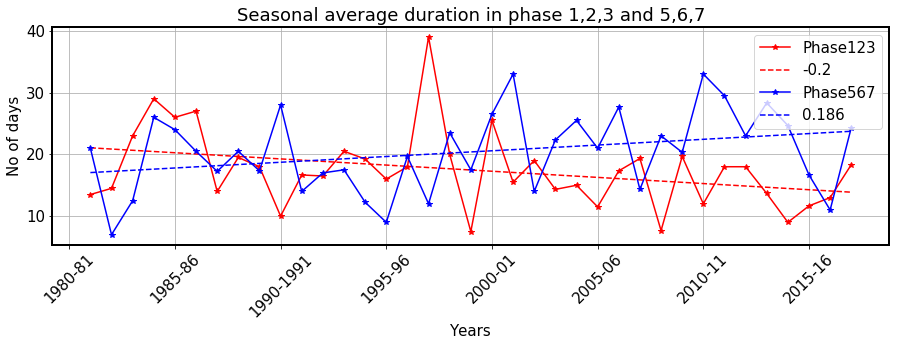

In [31]:
plt.figure(figsize=(15,4))
xx=np.arange(1,len(rmm_anal_av)+1)
# slope1,intercept1,t_score1,t_critical1,p1,corr1,p_data1=linear_regress_trend(xx,av_123,0.975)
# slope2,intercept2,t_score2,t_critical2,p2,corr2,p_data2=linear_regress_trend(xx,av_567,0.975)

slope1,intercept1,p1,corr1,h1=rig.linear_regress_scipy(xx,rmm_anal_av['p123'],0.05,opt_detrend=0,opt_mktest=0)
slope2,intercept2,p2,corr2,h2=rig.linear_regress_scipy(xx,rmm_anal_av['p567'],0.05,opt_detrend=0,opt_mktest=0)

plt.plot(xx,rmm_anal_av['p123'],'-*r')
plt.plot(xx,slope1*xx+intercept1,'r',linestyle='--')

plt.plot(xx,rmm_anal_av['p567'],'-*b')
plt.plot(xx,slope2*xx+intercept2,'b',linestyle='--')

plt.legend(['Phase123',str(round(slope1,3)),'Phase567',str(round(slope2,3))])
plt.xlabel('Years')
plt.ylabel('No of days')
plt.title('Seasonal average duration in phase 1,2,3 and 5,6,7')
plt.xticks(range(0, 38,5),['1980-81', '1985-86', '1990-1991','1995-96','2000-01','2005-06','2010-11','2015-16'],rotation=45)
plt.grid()
# plt.savefig("trend_season_average_123_567_88_adding.pdf",format='pdf', dpi=1000)
p1,p2

## Total Lifespan


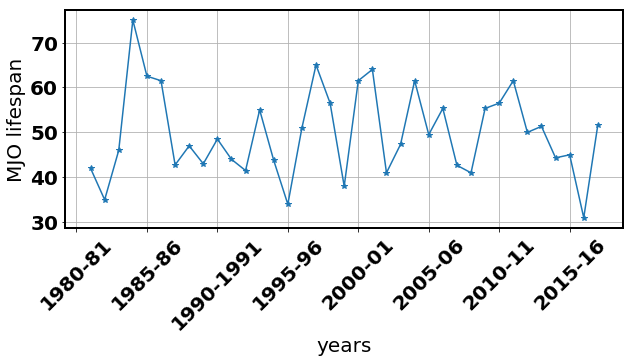

In [14]:
plt.figure(figsize=(10,4))
plt.plot(range(1, 38,1),rmm_anal_av['lf'],'-*')
plt.xticks(range(0, 38,5),['1980-81', '1985-86', '1990-1991','1995-96','2000-01','2005-06','2010-11','2015-16'],rotation=45)
plt.xlabel('years')
plt.ylabel('MJO lifespan')
plt.grid()
# plt.savefig('total_lifespan.pdf')

## MJO Phase Frequency analysis :
### Phase frequency calculation:

In [15]:
def phase_freq_cal(ph1,a1,range1,range2,inc,opt):
    threshold=np.arange(range1,range2,inc)
    t123=np.zeros((37,len(threshold)))
    t567=np.zeros((37,len(threshold)))
    k=0
    for n in threshold:  #### varyng threshold for MJO frequency count from 0.7 to 1.5
        a=[];p=[];
        for i in np.arange(37):
            a=a1[i]*1
            p=ph1[i]*1
            if opt:
                a_temp      =   (a>n)*1
                new_arr,seg =   mfs.select_seg(a_temp)
                p=p*new_arr
            else:
                p[a<n]=0

            t123[i,k]=np.size(np.where(p==1)[0])+np.size(np.where(p==2)[0])+np.size(np.where(p==3)[0])
            t567[i,k]=np.size(np.where(p==5)[0])+np.size(np.where(p==6)[0])+np.size(np.where(p==7)[0])

        k=k+1
    
    return t123,t567

## NDJFMA/NDJFM/DJFMA/DJFM:


Text(0, 0.5, 'total duration')

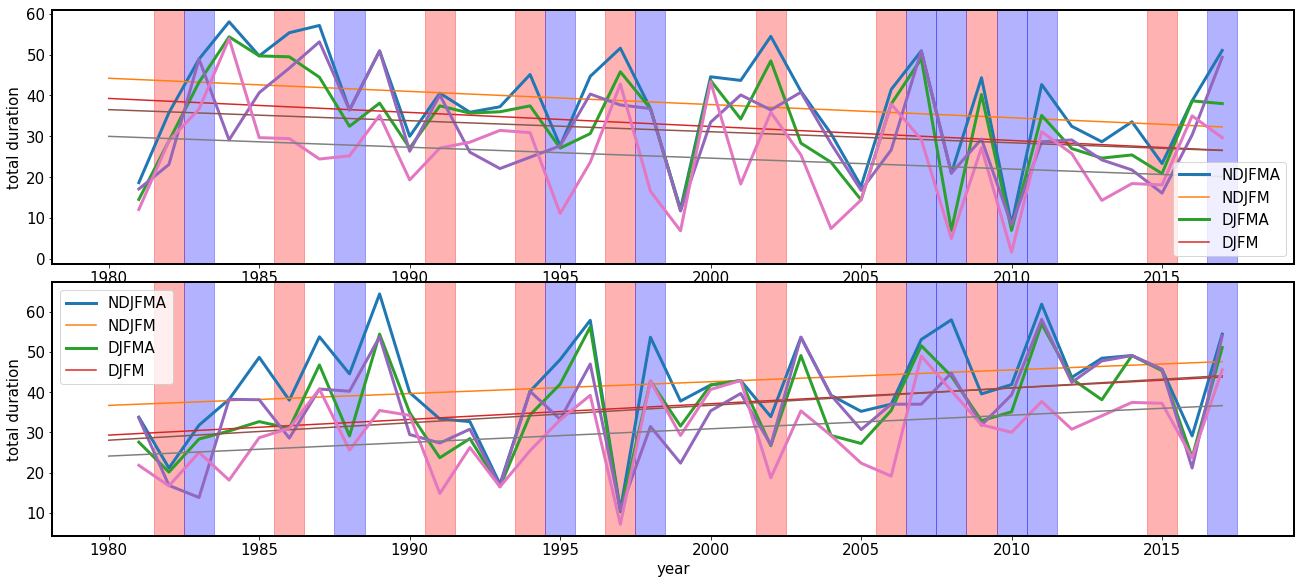

In [41]:
range1=0.7;range2=1.6;inc=0.1

strt_ind1=np.where(year==1982)[0][0]-61
strt_ind2=np.where(year==1982)[0][0]-31

ph1_ndjfma,a1_ndjfma=mfs.theta1_winter(theta1_rmm_org,MJO_index_rmm_org,1981,37,strt_ind1,181)
ph1_ndjfm,a1_ndjfm=mfs.theta1_winter(theta1_rmm_org,MJO_index_rmm_org,1981,37,strt_ind1,151)
ph1_djfma,a1_djfma=mfs.theta1_winter(theta1_rmm_org,MJO_index_rmm_org,1981,37,strt_ind2,151)
ph1_djfm,a1_djfm=mfs.theta1_winter(theta1_rmm_org,MJO_index_rmm_org,1981,37,strt_ind1,121)

range1=0.7;range2=1.6;inc=0.1



t123_ndjfma,t567_ndjfma=phase_freq_cal(ph1_ndjfma,a1_ndjfma,range1,range2,inc,opt=0)
t123_ndjfm,t567_ndjfm=phase_freq_cal(ph1_ndjfm,a1_ndjfm,range1,range2,inc,opt=0)
t123_djfma,t567_djfma=phase_freq_cal(ph1_djfma,a1_djfma,range1,range2,inc,opt=0)
t123_djfm,t567_djfm=phase_freq_cal(ph1_djfm,a1_djfm,range1,range2,inc,opt=0)

c123=np.zeros((4,), dtype=np.object)
c123[0]=t123_ndjfma;c123[1]=t123_ndjfm;c123[2]=t123_djfma;c123[3]=t123_djfm

fig = plt.figure(constrained_layout=True,figsize=(18,8))
ax1 = fig.add_subplot(2,1,1)
for i in np.arange(4):
    t=np.arange(1,38,1)
    ax1.plot(t,np.mean(c123[i],axis=1),linewidth=3.0)
    slope1, intercept1, p_value1, r_value1, std_err = stats.linregress(np.arange(1,len(c123[i])+1),np.mean(c123[i],axis=1))
    ax1.plot(slope1*np.arange(1,39,1)+intercept1)
for i in [2,6,11,14,17,22,26,29,35]:
    ax1.axvspan(i-0.5,i+0.5, alpha=0.3, color='red')

for i in [3,8,15,18,27,28,30,31,37]:
    ax1.axvspan(i-0.5,i+0.5, alpha=0.3, color='blue')

ax1.legend(['NDJFMA','NDJFM','DJFMA','DJFM'])
ax1.set_xticks(np.arange(0,38,5))
ax1.set_xticklabels(['1980','1985','1990','1995','2000','2005','2010','2015'])

ax1.set_xlabel('year')
ax1.set_ylabel('total duration')


c567=np.zeros((4,), dtype=np.object)
c567[0]=t567_ndjfma;c567[1]=t567_ndjfm;c567[2]=t567_djfma;c567[3]=t567_djfm
ax2 = fig.add_subplot(2,1,2)

for i in np.arange(4):
    t=np.arange(1,38,1)
    ax2.plot(t,np.mean(c567[i],axis=1),linewidth=3.0)
    slope1, intercept1,p_value1, r_value1,std_err = stats.linregress(np.arange(1,len(c567[i])+1),np.mean(c567[i],axis=1))
    ax2.plot(slope1*np.arange(1,39,1)+intercept1)
for i in [2,6,11,14,17,22,26,29,35]:
    ax2.axvspan(i-0.5,i+0.5, alpha=0.3, color='red')

for i in [3,8,15,18,27,28,30,31,37]:
    ax2.axvspan(i-0.5,i+0.5, alpha=0.3, color='blue')

ax2.legend(['NDJFMA','NDJFM','DJFMA','DJFM'])
ax2.set_xticks(np.arange(0,38,5))
ax2.set_xticklabels(['1980','1985','1990','1995','2000','2005','2010','2015'])

ax2.set_xlabel('year')
ax2.set_ylabel('total duration')


## Phase occurances in NDJFMA and Average MJO phase durations:

/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


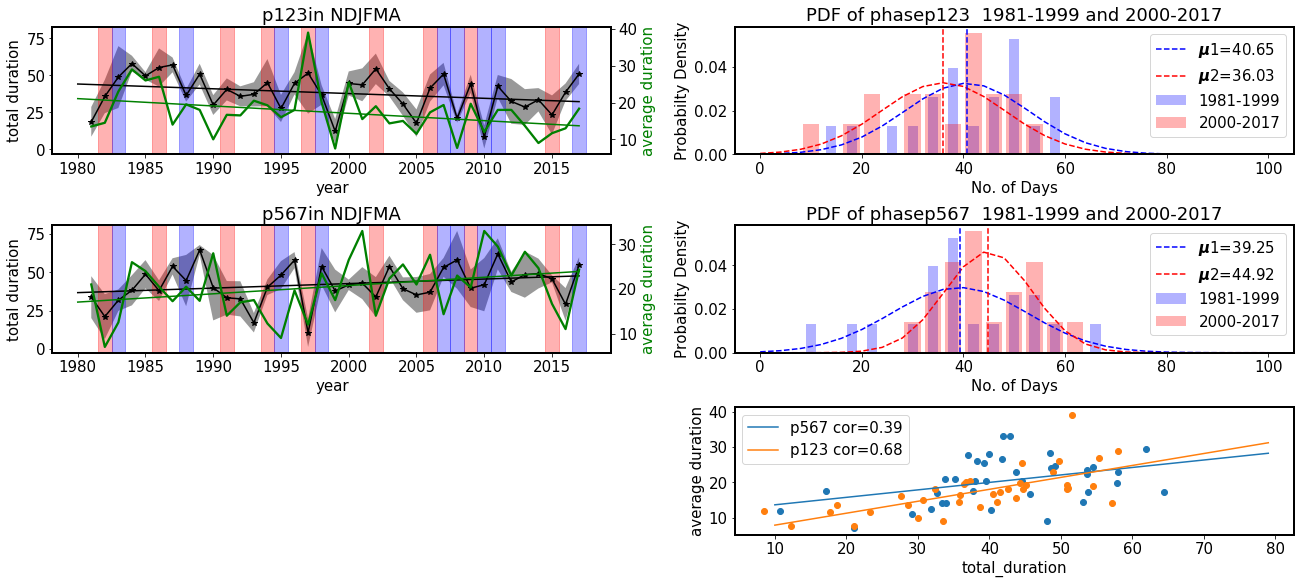

In [35]:
# fig,ax=plt.subplots(2,2,f)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure(constrained_layout=True,figsize=(18,8))
gs = fig.add_gridspec(3,2)
li=['p123','p567']
aa=np.zeros((2,), dtype=np.object)
aa[0]=t123_ndjfma;aa[1]=t567_ndjfma

for j in np.arange(2):
    ax = fig.add_subplot(gs[j,:-1])
    ii=aa[j]
    
    t=np.arange(1,38,1)
    mu1=np.mean(ii,axis=1)
    sigma1=np.std(ii,axis=1)
    ax.plot(t,mu1,'-*k')
    ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='grey', alpha=0.8)



    slope1, intercept1, p_value1,r_value,std_err = stats.linregress(np.arange(1,len(t123_ndjfma)+1),np.mean(ii,axis=1))
    ax.plot(slope1*np.arange(1,39,1)+intercept1,'k')
    plt.xticks(np.arange(0,38,5),['1980','1985','1990','1995','2000','2005','2010','2015'])
    ax.set_title(li[j]+'in NDJFMA')
    ax.set_xlabel('year')
    ax.set_ylabel('total duration')
    for i in [2,6,11,14,17,22,26,29,35]:
        ax.axvspan(i-0.5,i+0.5, alpha=0.3, color='red')

    for i in [3,8,15,18,27,28,30,31,37]:
        ax.axvspan(i-0.5,i+0.5, alpha=0.3, color='blue')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(t,rmm_anal_av[li[j]],'green',linewidth=2.3)
    slope2, intercept2, r_value, p_value2, std_err = stats.linregress(np.arange(1,len(t123_ndjfma)+1),rmm_anal_av[li[j]])
    ax2.plot(slope2*np.arange(1,39,1)+intercept2,'green')
    ax2.set_ylabel('average duration',color='green')
    
    
    
    no_ist=np.mean(ii,axis=1)[0:19]
    no_2nd=np.mean(ii,axis=1)[19:]
    bins = np.linspace(0,100, 26)



    mu1, std1 = norm.fit(no_ist)
    mu2, std2 = norm.fit(no_2nd)
    y1 = mlab.normpdf(bins, mu1, std1)
    y2 = mlab.normpdf(bins, mu2, std2)
    
    ax4 = fig.add_subplot(gs[j,1:])

    ax4.hist(no_ist, bins, normed=1, facecolor='blue', alpha=0.3,rwidth=0.5)
    ax4.plot(bins, y1, 'b--')
    ax4.hist(no_2nd, bins, normed=1, facecolor='red', alpha=0.3,rwidth=0.8)
    ax4.plot(bins, y2, 'r--')


    plt.xlabel('No. of Days')
    plt.ylabel('Probabilty Density')
    plt.legend(['$\mu$1='+str(round(mu1,2)),'$\mu$2='+str(round(mu2,2)),'1981-1999','2000-2017',])
    plt.axvline(x=mu1,color='b',linestyle='--')
    plt.axvline(x=mu2,color='r',linestyle='--')
    plt.title("PDF of phase"+li[j]+"  1981-1999 and 2000-2017")

    
s1=round(np.corrcoef(np.mean(t123_ndjfma,axis=1),rmm_anal_av['p123'])[0,1],2)
s2=round(np.corrcoef(np.mean(t567_ndjfma,axis=1),rmm_anal_av['p567'])[0,1],2)

ax3=fig.add_subplot(gs[2:,1:])
ax3.scatter(np.mean(t567_ndjfma,axis=1),rmm_anal_av['p567'])
slope, intercept, p_value,r_value, std_err = stats.linregress(np.mean(t567_ndjfma,axis=1),rmm_anal_av['p567'].values)
ax3.plot(np.arange(10,80,1),slope*np.arange(10,80,1)+intercept)
ax3.set_xlabel('total_duration')
ax3.set_ylabel('average duration')

ax4=fig.add_subplot(gs[2:,1:])
ax4.scatter(np.mean(t123_ndjfma,axis=1),rmm_anal_av['p123'])
slope, intercept, p_value,r_value, std_err = stats.linregress(np.mean(t123_ndjfma,axis=1),rmm_anal_av['p123'].values)
ax4.plot(np.arange(10,80,1),slope*np.arange(10,80,1)+intercept)
ax4.legend(['p567 cor='+str(s2),'p123 cor='+str(s1)])

## flitering 2-6 year variability from NDJFMA phase occurances and average phase duration:

In [18]:
# signal=np.mean(t123,axis=1)
ltime_period=2
htime_period=6
sample_freq=1

av_rm_enso_123=rmm_anal_av['p123'].values-filter_signal_scipy(rmm_anal_av['p123'].values,sample_freq,ltime_period,htime_period,opt_show_psd=0,keep_mean=0)
av_rm_enso_567=rmm_anal_av['p567'].values-filter_signal_scipy(rmm_anal_av['p567'].values,sample_freq,ltime_period,htime_period,opt_show_psd=0,keep_mean=0)
po_rm_enso_123=np.mean(t123_ndjfma,axis=1)-filter_signal_scipy(np.mean(t123_ndjfma,axis=1),sample_freq,ltime_period,htime_period,opt_show_psd=0,keep_mean=0)
po_rm_enso_567=np.mean(t567_ndjfma,axis=1)-filter_signal_scipy(np.mean(t567_ndjfma,axis=1),sample_freq,ltime_period,htime_period,opt_show_psd=0,keep_mean=0)

mk_test(av_rm_enso_123,alpha=0.06),mk_test(av_rm_enso_567,alpha=0.06),mk_test(po_rm_enso_123,alpha=0.06),mk_test(po_rm_enso_567,alpha=0.06)

/home/panini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


(('decreasing', True, 0.028949526520998248, (-2.1841731580935693+0j)),
 ('increasing', True, 0.0270822041875316, (2.2103309204659474+0j)),
 ('decreasing', True, 0.04003531627596213, (-2.0533843462316788+0j)),
 ('increasing', True, 0.04538497377656192, (2.0010688214869226+0j)))

## Correlation with seasonal mean sst and precipitation

/home/panini/Desktop/JGRJD_nature/jgrjd_nature_github_jgrjd/regression_analysis.py:301: ComplexWarning: Casting complex values to real discards the imaginary part
  regress_map[0,j,i]= slope
/home/panini/Desktop/JGRJD_nature/jgrjd_nature_github_jgrjd/regression_analysis.py:302: ComplexWarning: Casting complex values to real discards the imaginary part
  cor_map[0,j,i]    = corr
/home/panini/Desktop/JGRJD_nature/jgrjd_nature_github_jgrjd/regression_analysis.py:301: ComplexWarning: Casting complex values to real discards the imaginary part
  regress_map[0,j,i]= slope
/home/panini/Desktop/JGRJD_nature/jgrjd_nature_github_jgrjd/regression_analysis.py:302: ComplexWarning: Casting complex values to real discards the imaginary part
  cor_map[0,j,i]    = corr
/home/panini/Desktop/JGRJD_nature/jgrjd_nature_github_jgrjd/regression_analysis.py:301: ComplexWarning: Casting complex values to real discards the imaginary part
  regress_map[0,j,i]= slope
/home/panini/Desktop/JGRJD_nature/jgrjd_nature_

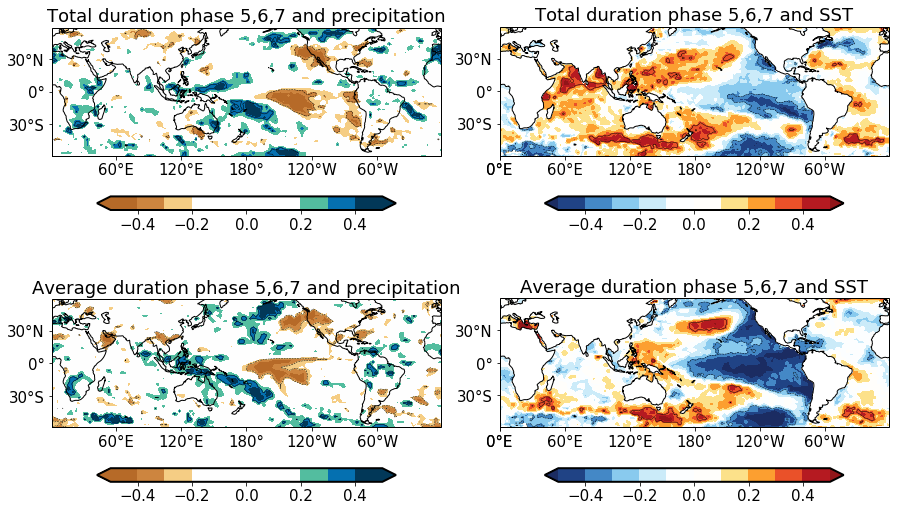

In [39]:
cmap1=nclcmaps.cmap('precip_diff_12lev')
cmap1.colors[4]=[0.99607843,0.99607843,0.99607843]
cmap1.colors[5]=[0.99607843,0.99607843,0.99607843]
cmap1.colors[7]=[0.99607843,0.99607843,0.99607843]
cmap1.colors[8]=[0.99607843,0.99607843,0.99607843]

cmap2 = nclcmaps.cmap('BlueWhiteOrangeRed')

data_name1='precip_raw_nov_apr_1981-2017.nc'
varname1='precip'

data_name2='sst_raw_nov_apr_1981-2017.nc'
varname2='sst'

f, ax = plt.subplots(2,2,figsize=(15,10))
plt.rcParams['font.size'] = 15



P1=rig.reg_plot(po_rm_enso_567,data_name1,varname1,alpha=0.05,opt_detrend=1,opt_mktest=0)
P1.draw_correlation_cartopy(0.33,-0.5,0.5,0.1,"Total duration phase 5,6,7 and precipitation",2,2,1,cmap=cmap1,draw_par=0)
P2=rig.reg_plot(po_rm_enso_567,data_name2,varname2,alpha=0.05,opt_detrend=1,opt_mktest=0)
P2.draw_correlation_cartopy(0.33,-0.5,0.5,0.1,"Total duration phase 5,6,7 and SST",2,2,2,cmap=cmap2,draw_par=0)


P3=rig.reg_plot(av_rm_enso_567,data_name1,varname1,alpha=0.05,opt_detrend=1,opt_mktest=0)
P3.draw_correlation_cartopy(0.3,-0.5,0.5,0.1,"Average duration phase 5,6,7 and precipitation",2,2,3,cmap=cmap1,draw_par=0)
P4=rig.reg_plot(av_rm_enso_567,data_name2,varname2,alpha=0.05,opt_detrend=1,opt_mktest=0)
P4.draw_correlation_cartopy(0.33,-0.5,0.5,0.1,"Average duration phase 5,6,7 and SST",2,2,4,cmap=cmap2,draw_par=0)

plt.subplots_adjust(wspace=0.15, hspace=0)


## Trend in precipitation and SST

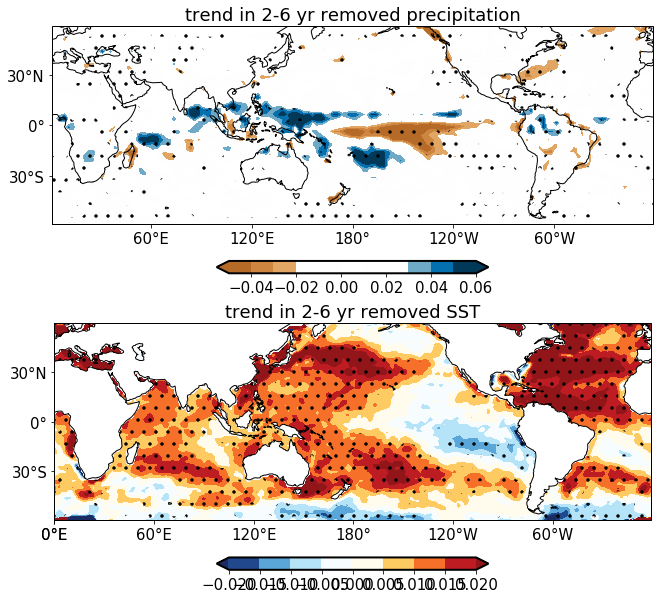

In [38]:

f, ax = plt.subplots(2,1,figsize=(15,10))
plt.rcParams['font.size'] = 15

t=np.arange(1,38,1)

P1=rig.reg_plot(t,data_name1,varname1,alpha=0.05,opt_detrend=0,opt_mktest=1)
P1.draw_regression_cartopy(-0.05,0.05,0.01,"trend in 2-6 yr removed precipitation",2,1,1,cmap=cmap1,hatch=".",draw_par=0)
P2=rig.reg_plot(t,data_name2,varname2,alpha=0.05,opt_detrend=0,opt_mktest=1)
P2.draw_regression_cartopy(-0.02,0.02,0.005,"trend in 2-6 yr removed SST",2,1,2,cmap=cmap2,hatch=".",draw_par=0)

plt.subplots_adjust(wspace=0.07, hspace=0.20)


## writing files

In [20]:
a=pd.read_csv('MJO_88_events.csv')
str_d=a['Starting date']

end_d=a['Ending date']
all_events=pd.concat([str_d,end_d,rmm_anal_ap],axis=1)
all_events.to_csv('MJO_history_88.csv')
rmm_anal_av.to_csv('Average_phase_duration_88_events_adding.csv')